# Regresión lineal múltiple

En este notebook vamos entrenar el mejor modelo posible para predecir la variable de la diabetes en el dataser de la diabetes.

Aprenderemos primero como hacer un modelo de regresión lineal múltiple y después qué estrategias hay para poder elegir el mejor modelo.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
%matplotlib inline

In [2]:
matplotlib.rcParams['figure.figsize'] = [20, 10]
matplotlib.rcParams['font.size'] = 20

In [3]:
diabetes = datasets.load_diabetes()

## Problema 1

__Pregunta principal__ ¿Cuál es el mejor modelo?

A. Modelo que predice diabetes usando el indice de masa corporal(body mass). Esto es un modelo de regresión lineal.


B. Modelo que predice diabetes usando todas las variables (10 variables). Esto es un modelo de regresión lineal múltiple.

## Contruccion de los modelos siguiento los 5 pasos

#### 1. Preparar los datos 

In [4]:
X = diabetes.data
y = diabetes.target

#### 2. Separar los datos de entrenamiento y test

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666, test_size=0.1)

#### 3. Construir los modelos

In [6]:
from sklearn.linear_model import LinearRegression
reg1 = LinearRegression()
reg2 = LinearRegression()

#### 4. Ajustar los modelos a los datos de entrenamiento

In [7]:
reg1.fit(X_train, y_train) # here we take all possible variables
reg2.fit(X_train[:, [2]], y_train) # here we choose only second column

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

#### 5. Evaluación de los modelos

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
y_test_hat1 = reg1.predict(X_test)
y_test_hat2 = reg2.predict(X_test[:, [2]])
print(np.sqrt(mean_squared_error(y_test, y_test_hat1)), np.sqrt(mean_squared_error(y_test, y_test_hat2)))

47.61322195051475 55.85346157514181


### Conclusión

El modelo con todas las variables tiene mejor performance que el modelo con una sola variable. 

## Problema 2

__Pregunta principal__ ¿Cuál es el mejor modelo posible teneindo en cuenta todas las variables?

### Caculemos todas las posibles combinaciones

In [9]:
from itertools import combinations

# 1. Prepare data.
X = diabetes.data
y = diabetes.target

# 2. Split data into train and test.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666, test_size=0.2)

# 3. Build a models and further data preparation for each model.
# 4. Fit models to train data on selected columns.
# 5. Evaluate models on test data and compare performance.

def fit_and_evaluate(columns, X_train, X_test, y_test):
    """
    Function that evaluate how model train on specific combination of columns performs
    
    columns: variable that that contains a list of columns that we use to train a particular model
    X_train: Dataset that we use to train the model
    X_test: Dataset that we use to test the model
    y_test: true predictions for test dataset
    
    returns: root means square error evaluated on test dataset
    """
    # Build the model
    reg = LinearRegression()
    
    # Fit the model to dataset with specific columns
    reg.fit(X_train[:, columns], y_train)
    
    # Evaluate models on test data.
    y_test_hat = reg.predict(X_test[:, columns])
    return np.sqrt(mean_squared_error(y_test, y_test_hat))

def get_performance_on_combinations_of_columns(X_train, X_test, y_test):
    """
    Function that generate all combination of columns
    and then evaluate how model train on that combinations performs
    
    X_train: Dataset that we use to train the model
    X_test: Dataset that we use to test the model
    y_test: true predictions for test dataset
    
    returns: DataFrame with
        - number of columns used
        - specific combination of columns
        - root means square error evaluated on test dataset
    """
    all_columns_num = X_train.shape[1]
    all_colnames = list(range(all_columns_num))
    
    performance = pd.DataFrame(
        columns=["n_columns", "columns", "RMSE"]
    )

    for columns_num in range(1, all_columns_num + 1):
        for columns in combinations(all_colnames, columns_num):
            rmse = fit_and_evaluate(columns, X_train, X_test, y_test)
            new_row = pd.DataFrame({
                "n_columns": [columns_num], 
                "columns": [columns], 
                "RMSE": [rmse]
            })
            performance = performance.append(new_row, ignore_index = True)  
    return performance

In [10]:
performance = get_performance_on_combinations_of_columns(X_train, X_test, y_test) 
        
print("El número total de combinaciones es {}.".format(len(performance)))

El número total de combinaciones es 1023.


Ahora vamos a buscar cúal es la mejor combinación, dibujando el valor del error RSM para cada una de las combinaciones

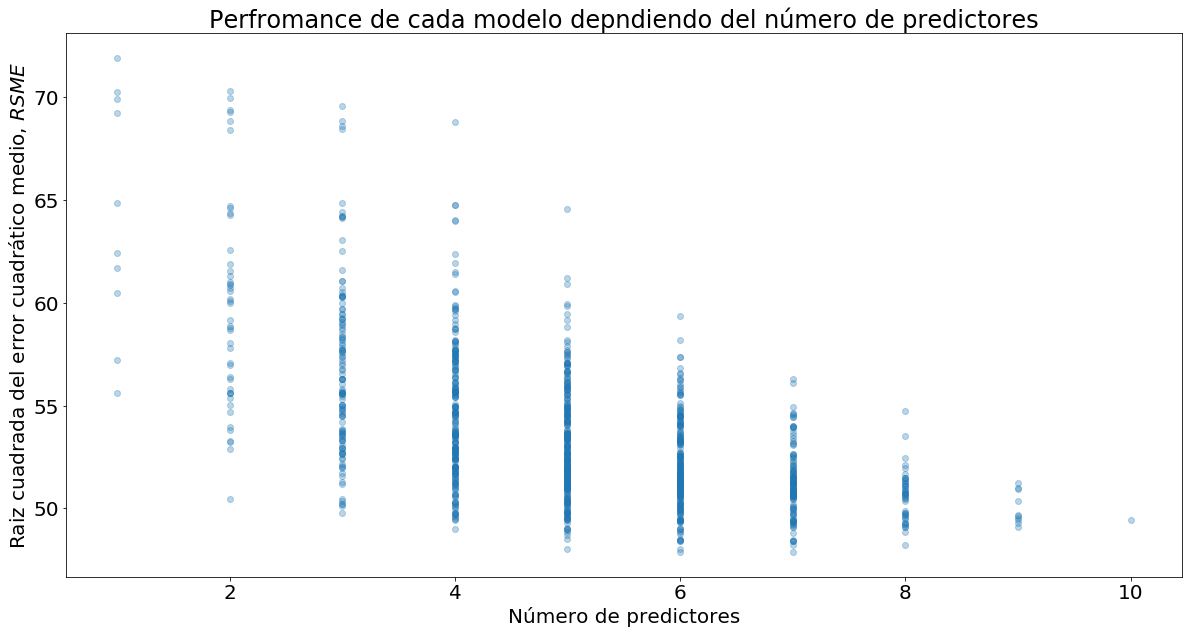

In [11]:
plt.scatter(performance["n_columns"], performance["RMSE"], alpha = 0.3)
plt.xlabel("Número de predictores")
plt.ylabel("Raiz cuadrada del error cuadrático medio, $RSME$")
plt.title("Perfromance de cada modelo depndiendo del número de predictores")
plt.show()

In [12]:
# Best performing models
performance.sort_values("RMSE").head()

,RMSE,columns,n_columns
781,47.880858,"(1, 2, 3, 6, 8, 9)",6
865,47.889001,"(0, 1, 2, 3, 6, 8, 9)",7
521,48.020136,"(1, 2, 3, 6, 8)",5
647,48.038394,"(0, 1, 2, 3, 6, 8)",6
981,48.210301,"(0, 1, 2, 3, 6, 7, 8, 9)",8


Así la mejor eleccion es eligiendo las columnas: `(1, 2, 3, 6, 8, 9)` que son

In [13]:
[diabetes.feature_names[i] for i in [1, 2, 3, 6, 8, 9]]

['sex', 'bmi', 'bp', 's3', 's5', 's6']

Let's see what are the parameters of this model.

In [14]:
best_reg = LinearRegression()
best_reg.fit(X_train[:, (1, 2, 3, 6, 8, 9)], y_train)
y_test_hat = best_reg.predict(X_test[:, (1, 2, 3, 6, 8, 9)])
print("Parameters a: ", best_reg.coef_)
print("Parameter b: ", best_reg.intercept_)

Parameters a:  [-225.78647725  533.21599131  319.5160069  -293.65810211  491.19212091
   35.45789137]
Parameter b:  153.00353416418773


### ¿Donde hemos cometido mayores errores?


VAmos a calcular para cada dato su error
$$e_i = y_i - \hat{y}_i$$

y lo dibujamos en el siguiente gráfico

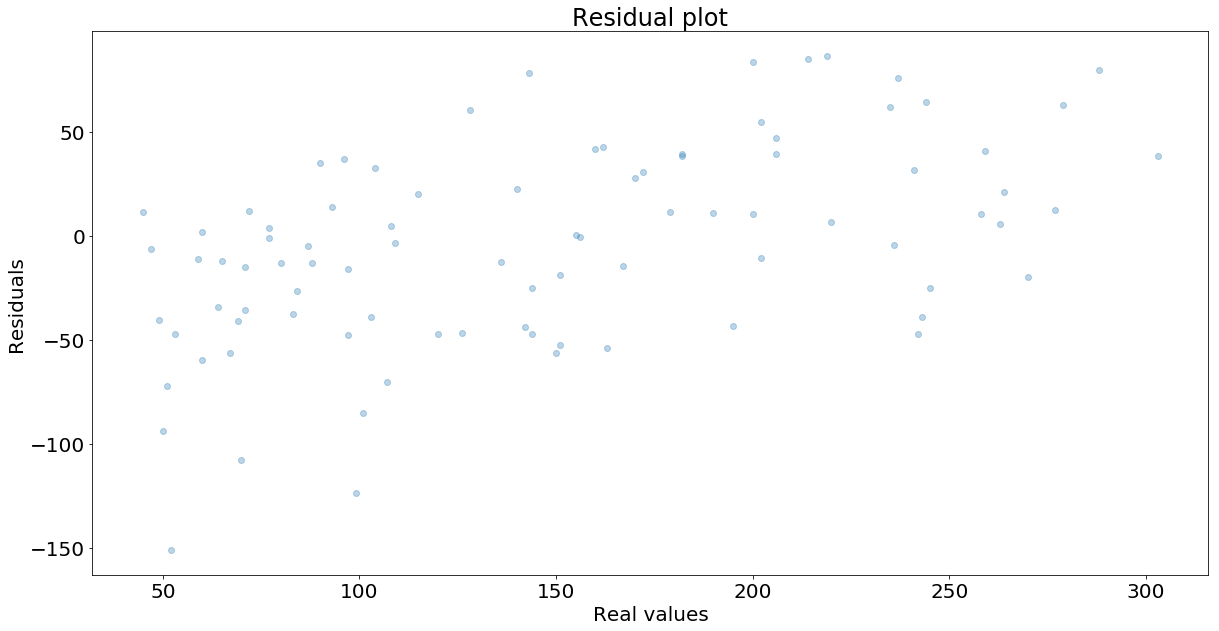

In [15]:
plt.scatter(y_test, y_test-y_test_hat, alpha = 0.3)
plt.xlabel("Real values")
plt.ylabel("Residuals")
plt.title("Residual plot")
plt.show()

## Problema 3

La elección del número de predictores y la selección de los predictores
son hiperparámetros del modelo. En estos casos es necesario para evitar overfittting
evaluar cada modelo en un conjunto de validación que construimos a continuación. Des este modo estaremos evaluando el modelo como corresponde.

#### Hyperparametros  train-dev-test separación

In [16]:
# 1. Prepare data.
X = diabetes.data
y = diabetes.target
# 2. Split data into train,  dev and test.
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, random_state=666, test_size=0.2)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, random_state=667, test_size=0.25)

In [17]:
len(y_train), len(y_dev), len(y_test)

(264, 89, 89)

In [18]:
# 3. Build models, fit them to train dataset and evaluate on dev dataset.

performance = get_performance_on_combinations_of_columns(X_train, X_dev, y_dev) 
performance.sort_values("RMSE").head()

,RMSE,columns,n_columns
765,56.184161,"(1, 2, 3, 4, 5, 8)",6
932,56.211273,"(1, 2, 3, 4, 5, 6, 8)",7
849,56.262737,"(0, 1, 2, 3, 4, 5, 8)",7
968,56.297644,"(0, 1, 2, 3, 4, 5, 6, 8)",8
936,56.301163,"(1, 2, 3, 4, 5, 8, 9)",7


In [19]:
# 4. Choose the hyperparameters of the model that performs best on dev.
best_columns = (1, 2, 3, 4, 5, 8)

# 5. Build and fit the model with these hyperparameters to both train and dev datasets.
c = LinearRegression()
best_reg.fit(X_train_dev[:, best_columns], y_train_dev)
y_test_hat = best_reg.predict(X_test[:, best_columns])
np.sqrt(mean_squared_error(y_test, y_test_hat))

49.320937456254434

In [20]:
[diabetes.feature_names[i] for i in [1, 2, 3, 4, 5, 8]]

['sex', 'bmi', 'bp', 's1', 's2', 's5']